In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_evolution_by_a(mean_trait, population_size, mean_fitness, a_values):
    """
    Plot the evolution of a quantitative trait in a population over a given number of generations
    for different values of selection strength.

    Parameters
    ----------
    mean_trait : list
        List of mean trait values per generation for each value of a.
    population_size : list
        List of population sizes per generation for each value of a.
    mean_fitness : list
        List of mean fitness values per generation for each value of a.
    a_values : array-like
        Array of selection strength values to plot.

    Returns
    -------
    None
        This function only plots the results.
    """

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

    for i, a in enumerate(a_values):
        axes[0].plot(range(len(population_size[i])), population_size[i], label=f"a={a:.2f}")
        axes[1].plot(range(len(mean_fitness[i])), mean_fitness[i], label=f"a={a:.2f}")
        axes[2].plot(range(len(mean_trait[i])), mean_trait[i], label=f"a={a:.2f}")

    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("Population size")
    axes[0].set_title("Population size over time")
    axes[0].legend()

    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Mean fitness")
    axes[1].set_title("Mean fitness over time")
    axes[1].legend()

    axes[2].set_xlabel("Generation")
    axes[2].set_ylabel("Mean trait value")
    axes[2].set_title("Mean trait value over time")
    axes[2].legend()

    fig.tight_layout()
    plt.show()


In [22]:
def plot_fitness_vs_selection_strength(s_range, v_list, num_replicates=5):
    # Initialize arrays to store fitness data
    fitness_data = np.zeros((len(v_list), len(s_range), num_replicates))
    
    # Iterate through selection strengths and environmental rates of change
    for i, v in enumerate(v_list):
        for j, s in enumerate(s_range):
            # Perform replicates for each selection strength
            for k in range(num_replicates):
                # Simulate evolution with current parameters
                mean_trait, population_size, mean_fitness = simulate_evolution(
                    pop_size=1000, 
                    num_generations=1000, 
                    r=1.0, 
                    K=1000, 
                    a=s, 
                    initial_theta=0.0, 
                    mu=0.0, 
                    sigma=1.0, 
                    fitness_threshold=0.02, 
                    v=v, 
                    pR=0.2
                )
                # Calculate average fitness relative to optimum fitness
                fitness_data[i,j,k] = np.mean(mean_fitness) / np.max(mean_fitness)
    
    # Calculate mean and standard deviation of fitness data
    mean_fitness_data = np.mean(fitness_data, axis=2)
    std_fitness_data = np.std(fitness_data, axis=2)
    
    # Plot fitness data as a function of selection strength
    fig, ax = plt.subplots()
    for i, v in enumerate(v_list):
        ax.plot(s_range, mean_fitness_data[i], label=f'v={v}', color=f'C{i}')
        ax.fill_between(s_range, mean_fitness_data[i] - std_fitness_data[i], mean_fitness_data[i] + std_fitness_data[i], alpha=0.2, color=f'C{i}')
    ax.set_xlabel('Selection Strength')
    ax.set_ylabel('Average Fitness (Relative to Optimum)')
    ax.legend()
    plt.show()


In [ ]:
def simulate_evolution(pop_size, num_generations, r, K, a, initial_theta, mu, sigma, fitness_threshold, v, pR):
    """
    Simulate the evolution of a quantitative trait in a population over a given number of generations
    with a time-dependent optimum trait value (theta) and plastic tolerance range (pR).

    Parameters
    ----------
    pop_size : int
        Size of the population.
    num_generations : int
        Number of generations to simulate.
    r : float
        Maximum fitness at low density with an optimal phenotype.
    K : float
        Carrying capacity.
    a : float
        Strength of stabilizing selection.
    initial_theta : float
        Initial optimal trait value for an environment.
    mu : float
        Mean of the initial population distribution.
    sigma : float
        Standard deviation of the initial population distribution.
    fitness_threshold : float
        Minimum fitness required for an individual to survive and reproduce.
    v : float
        Rate of environmental change.
    pR : float
        Plastic tolerance range, the equidistant range around the trait value where the fitness
        is not affected by stabilizing selection.

    Returns
    -------
    mean_trait : list
        List of mean trait values per generation.
    population_size : list
        List of population sizes per generation.
    mean_fitness : list
        List of mean fitness values per generation.
    """
    
    # Initialize population
    pop = np.random.normal(loc=mu, scale=sigma, size=pop_size)

    # Simulate evolution
    mean_trait = []
    population_size = []
    mean_fitness = []
    for gen in range(num_generations):
        # Update optimal trait value based on time
        theta = initial_theta + v * gen

        # Calculate centerDist
        centerDist = pop - theta

        # Calculate the expressed trait value based on the centerDist and pR
        expressed_trait = np.where(np.abs(centerDist) > pR, centerDist - np.sign(centerDist) * pR, centerDist)

        # Calculate fitness based on the new fitness calculation
        w = r * (1 - (pop_size / K)) - (a / 2) * expressed_trait**2
        w = np.exp(w)  # Convert to probability

        # Survival and reproduction based on fitness threshold
        survivors = pop[w >= fitness_threshold]
        if len(survivors) == 0:
            # Extinction occurs
            break
        
        w = w[w >= fitness_threshold]
        w /= np.sum(w)

        # Select parents
        parents = np.random.choice(survivors, size=len(survivors), p=w, replace=True)
        
        # Create offspring + ADD PERTURBATION HERE !!!
        offspring = np.random.normal(loc=parents, scale=sigma, size=len(parents))
        
        # Update population
        pop = offspring
        pop_size = len(pop)

        # Store mean trait, population size, and mean fitness
        mean_trait.append(np.mean(pop))
        population_size.append(pop_size)
        mean_fitness.append(np.mean(w))

    return mean_trait, population_size, mean_fitness


In [ ]:
# Define parameter values
pop_size = 1000
num_generations = 100
r = 1
K = 1000
theta = 0
mu = 0
sigma = 1
fitness_threshold = 0.01
v = 0.2
pR = 10.0

# Define range of selection strengths to simulate
a_values = np.linspace(0.1, 2.0, num=10)

# Initialize lists to store output values for each value of a
mean_trait = []
population_size = []
mean_fitness = []

# Loop over selection strengths and simulate evolution
for a in a_values:
    # Run simulation
    trait, size, fitness = simulate_evolution(pop_size, num_generations, r, K, a, theta, mu, sigma, fitness_threshold, v, pR)

    # Store output values
    mean_trait.append(trait)
    population_size.append(size)
    mean_fitness.append(fitness)

# Plot results
plot_evolution_by_a(mean_trait, population_size, mean_fitness, a_values)



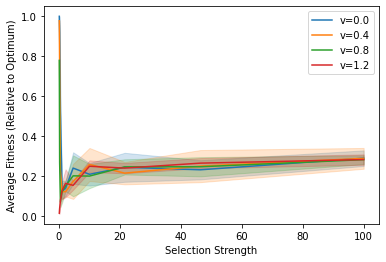

In [24]:
# Define selection strengths to iterate over
s_range =np.logspace(-1, 2, num = 10, base = 10)

# Define list of environmental rates of change
v_list = [0.0, 0.4, 0.8, 1.2]

# Call the function
plot_fitness_vs_selection_strength(s_range, v_list, num_replicates = 5)
